# Eddy buoyancy fluxes

While we have worked with multiple tracers to estimate the diffusivity tensor, it remains to be known what one can do only with knowledge of buoyancy. This is practically important for a number of reasons: 

- Previous investigators have worked in terms of buoyancy when thinking about Kgm, and eddy volume fluxes. It will only be reasonable to catch up to their work. 
- There are physical implications of Kgm, such as reduction in APE, does the Kgm estimated from tracers approximate this? 
- Some recent work, Chapman and Sallee 2017, has looked at the potential of using Argo floats in estimating the eddy heat fluxes. It would be interesting to see if it is potentially possible to recoved a Kgm obs from this work. 

Rotational fluxes are a pesky issue, and investigations with zonal channels have managed to get around this with ease. If we are to make any real progress towards improving 3D models, it would be useful to see how the 2D results translate into a 3D ocean. 

Different ways to estimate the buoyancy diffusivity in the ocean: 

** w'b' method **

using the eddy buoyancy variance equation.

**Raw **
\begin{equation}
\kappa_{raw} =  - |\nabla_h \overline{b}|^{-2} \overline{\mathbf{u}'_hb'} . \nabla_h \overline{b}
\end{equation}
\begin{equation}
\nu_{raw} =  - |\nabla_h \overline{b}|^{-2} \overline{\mathbf{u}'_hb'} .(\mathbf{k} \times \nabla_h \overline{b})
\end{equation}

** Marshall and Shutts Rotational **

** Medvedev and Greatbach **




# Eddy APE equation. 

Instead the eddy buoyancy variance budget
\begin{equation}
\frac{\partial \overline{b'^2}/2}{\partial t} + \nabla_h. \overline{ \mathbf{u}_g b'^2}/2 = -\overline{b' \mathbf{u}_g'}.\nabla_h \overline{b} - \overline{w'b'} N^2 + \overline{D'/F'b'}
\end{equation}

... 

The second term on the LHS has not been calculated online, so we will try to calculate it offline. 

In [1]:
# load modules 
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
from matplotlib import colors, ticker, cm
from matplotlib.colors import LogNorm
%matplotlib inline
import os 
from xgcm import Grid
from xarrayutils import aggregate
import copy
# Pseudo Inversion 
from scipy.linalg import pinv, eig 

In [2]:
data_dir = '/swot/SUM05/dbalwada/channel_model_output/varying_res/05km/multi_tracer_montly_restored/multi_tracer/'

# brief comment on how often was the model data saved 
# the mode outputs fields every 5 days, averages are also
# calculated over 5 days (*this creates stupid amounts of 
# unnecessary data, and was definitely a terrible idea in hidsight).
 
iters = range(10473120, 10473120+518400*4, 1440)
model_vars = ['uVeltave','vVeltave','wVeltave', 'Ttave', 
               'UTtave','VTtave', 'TTtave', 'WTtave']
ds_model = open_mdsdataset(data_dir , delta_t=300, iters=iters, 
                          prefix=model_vars,
                          ignore_unknown_vars=True, geometry='cartesian')

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [3]:
# Means of all the fields in time.
Model_tav = ds_model.mean('time')
Model_tav.load()

<xarray.Dataset>
Dimensions:   (XC: 400, XG: 400, YC: 400, YG: 400, Z: 40, Zl: 40, Zp1: 41, Zu: 40)
Coordinates:
  * YG        (YG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * YC        (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * XG        (XG) >f4 0.0 5000.0 10000.0 ... 1985000.0 1990000.0 1995000.0
  * XC        (XC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * Zu        (Zu) >f4 -10.0 -20.0 -30.0 -42.0 ... -2779.0 -2882.0 -2985.0
  * Z         (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2624.5 -2727.5 -2830.5 -2933.5
  * Zp1       (Zp1) >f4 0.0 -10.0 -20.0 -30.0 ... -2779.0 -2882.0 -2985.0
  * Zl        (Zl) >f4 0.0 -10.0 -20.0 -30.0 ... -2573.0 -2676.0 -2779.0 -2882.0
    dxG       (YG, XC) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    Depth     (YC, XC) >f4 0.0 0.0 0.0 0.0 0.0 ... 2985.0 2985.0 2985.0 2985.0
    dyG       (YC, XG) >f4 5000.0 5000.0 5000.0 5000.0 ... 5000.0 5000.0 5000.0
    rAs       (YG, XC) >f4 

In [7]:
alpha = 2e-4

In [10]:
grid = Grid(Model_tav, periodic='X')

In [24]:
# b'b' = 2phi
bpbp = alpha**2*(Model_tav.TTtave - Model_tav.Ttave**2)

In [26]:
# Mean flux of buoyancy variance
# ubar phi_bar + vbar phi_bar

Uphi = grid.interp(Model_tav.uVeltave, 'X') * bpbp
Vphi = grid.interp(Model_tav.vVeltave, 'Y', boundary='extend') * bpbp

In [31]:
# Eddy flux of buoyancy variance (triple correlation)
# not calculated properly online!!!
# u' phibar' 

up = ds_model.uVeltave - Model_tav.uVeltave
vp = ds_model.vVeltave - Model_tav.vVeltave
bp = alpha*(ds_model.Ttave - Model_tav.Ttave)

bbp = alpha**2 *( ds_model.TTtave - Model_tav.Ttave**2)

upphip1 = (grid.interp(up, 'X') * bp *bp).mean('time').load()
vpphip1 = (grid.interp(vp, 'Y', boundary='extend') * bp *bp).mean('time').load()
upphip2 = (grid.interp(up, 'X') * bbp).mean('time').load()
vpphip2 = (grid.interp(vp, 'Y', boundary='extend') * bbp).mean('time').load()

In [42]:
# Eddy fluxes of buoyancy
# u'b' 
upbp = alpha* grid.interp(Model_tav.UTtave - Model_tav.uVeltave*grid.interp(Model_tav.Ttave, 'X'),
                         'X')

# v'b'
vpbp = alpha* grid.interp(Model_tav.VTtave - Model_tav.vVeltave*grid.interp(Model_tav.Ttave, 'Y', boundary='extend'),
                         'Y', boundary='extend')

# w'b' 
wpbp = alpha* grid.interp(Model_tav.WTtave - 
    Model_tav.wVeltave*grid.interp(Model_tav.Ttave, 'Z', boundary='extend'), 'Z', boundary='extend')

In [43]:
# Buoyancy gradients 

# Function to calculate the gradients
def tracer_grads(ds, ds_full):
    
    grid = Grid(ds_full, periodic='X')
    
    dx = ds_full.dxC.mean('YC')
    dy = ds_full.dyC.mean('XC')
    dz = ds_full.drF
    
    trac_dx = grid.interp(grid.diff(ds,'X')/dx, 'X')
    
    trac_dy = grid.interp(grid.diff(ds,'Y', boundary = 'extend')/dy, 'Y',boundary='extend')
    
    trac_dz = - grid.interp(grid.diff(ds,'Z', boundary = 'extend'), 'Z',boundary='extend')/dz

    trac_dx= trac_dx.rename('dcdx')
    trac_dy= trac_dy.rename('dcdy')
    trac_dz= trac_dz.rename('dcdz')
    
    grads = xr.merge([trac_dx, trac_dy, trac_dz])
    return grads


In [44]:
bgrads = alpha*tracer_grads(Model_tav.Ttave, Model_tav)

In [45]:
bgrads

<xarray.Dataset>
Dimensions:  (XC: 400, YC: 400, Z: 40)
Coordinates:
  * Z        (Z) >f4 -5.0 -15.0 -25.0 -36.0 ... -2624.5 -2727.5 -2830.5 -2933.5
    PHrefC   (Z) >f4 49.05 147.15 245.25 ... 26756.775 27767.205 28777.635
  * XC       (XC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
  * YC       (YC) >f4 2500.0 7500.0 12500.0 ... 1987500.0 1992500.0 1997500.0
    drF      (Z) >f4 10.0 10.0 10.0 12.0 14.0 ... 103.0 103.0 103.0 103.0 103.0
Data variables:
    dcdx     (Z, YC, XC) float32 0.0 0.0 0.0 ... -6.3344837e-13 -4.2259693e-13
    dcdy     (Z, YC, XC) float32 1.5962238e-08 1.595916e-08 ... 3.5439433e-11
    dcdz     (Z, YC, XC) float32 0.0 0.0 0.0 ... 2.487539e-09 2.4919227e-09

In [50]:
LU =  Uphi + upphip1
LU2 =  Uphi + upphip2

In [60]:
LV =  Vphi + vpphip1
LV2 =  Vphi + vpphip2

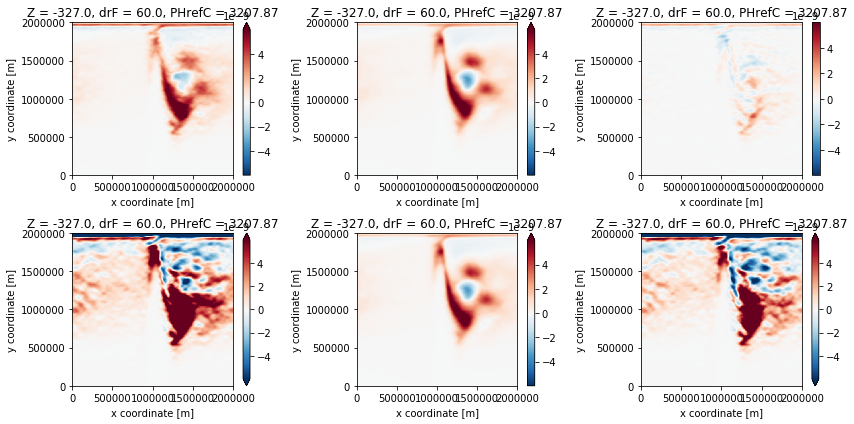

In [53]:
fig = plt.figure(figsize=(12,6))

fig.add_subplot(231)
LU.sel(Z=-300, method='nearest').plot(vmin=-6e-9)

fig.add_subplot(232)
Uphi.sel(Z=-300, method='nearest').plot(vmin=-6e-9)

fig.add_subplot(233)
upphip1.sel(Z=-300, method='nearest').plot(vmin=-6e-9)

fig.add_subplot(234)
LU2.sel(Z=-300, method='nearest').plot(vmin=-6e-9)

fig.add_subplot(235)
Uphi.sel(Z=-300, method='nearest').plot(vmin=-6e-9)

fig.add_subplot(236)
upphip2.sel(Z=-300, method='nearest').plot(vmin=-6e-9)

plt.tight_layout()

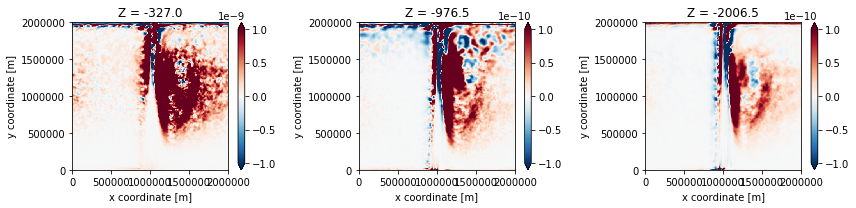

In [67]:
fig = plt.figure(figsize=(12,3))

fig.add_subplot(131)
wpbp.sel(Z=-300, method='nearest').plot(vmin=-1e-9)

fig.add_subplot(132)
wpbp.sel(Z=-1000, method='nearest').plot(vmin=-1e-10)

fig.add_subplot(133)
wpbp.sel(Z=-2000, method='nearest').plot(vmin=-1e-10)

plt.tight_layout()


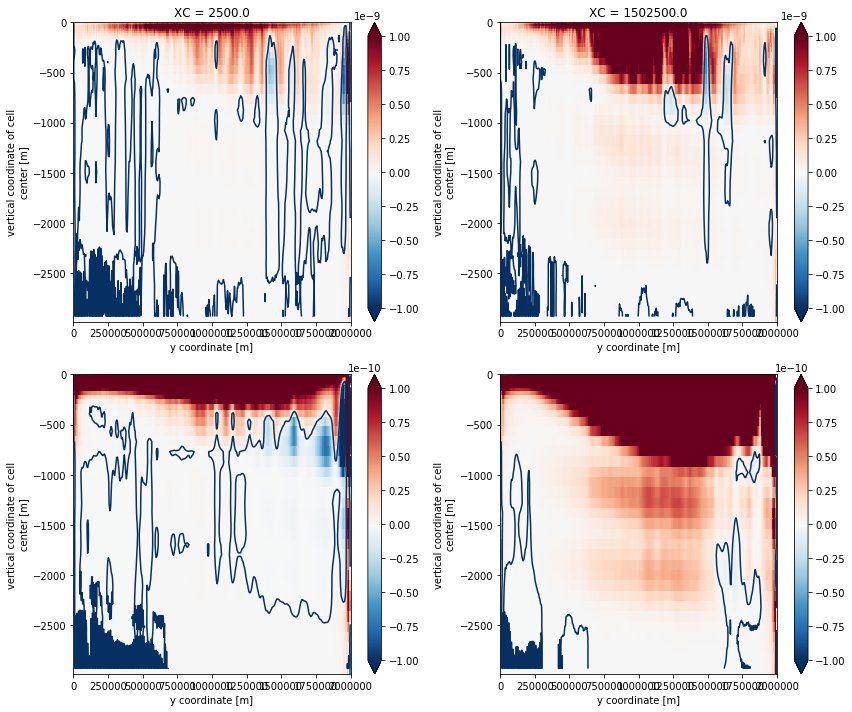

In [73]:
fig = plt.figure(figsize=(12,10))

fig.add_subplot(221)
wpbp.sel(XC=0, method='nearest').plot(vmin=-1e-9)
wpbp.sel(XC=0, method='nearest').plot.contour(levels=[0])

fig.add_subplot(222)
wpbp.sel(XC=1500e3, method='nearest').plot(vmin=-1e-9)
wpbp.sel(XC=1500e3, method='nearest').plot.contour(levels=[0])


fig.add_subplot(223)
wpbp.sel(XC=slice(0, 800e3)).mean('XC').plot(vmin=-1e-10)
wpbp.sel(XC=slice(0, 800e3)).mean('XC').plot.contour(levels=[0])


fig.add_subplot(224)
wpbp.sel(XC=slice(1200, 2000e3)).mean('XC').plot(vmin=-1e-10)
wpbp.sel(XC=slice(1200, 2000e3)).mean('XC').plot.contour(levels=[0])

plt.tight_layout()


In [74]:
# wpbp/|gradb|^2

Kwpbp = wpbp/(bgrads.dcdx**2 + bgrads.dcdy**2)*bgrads.dcdz

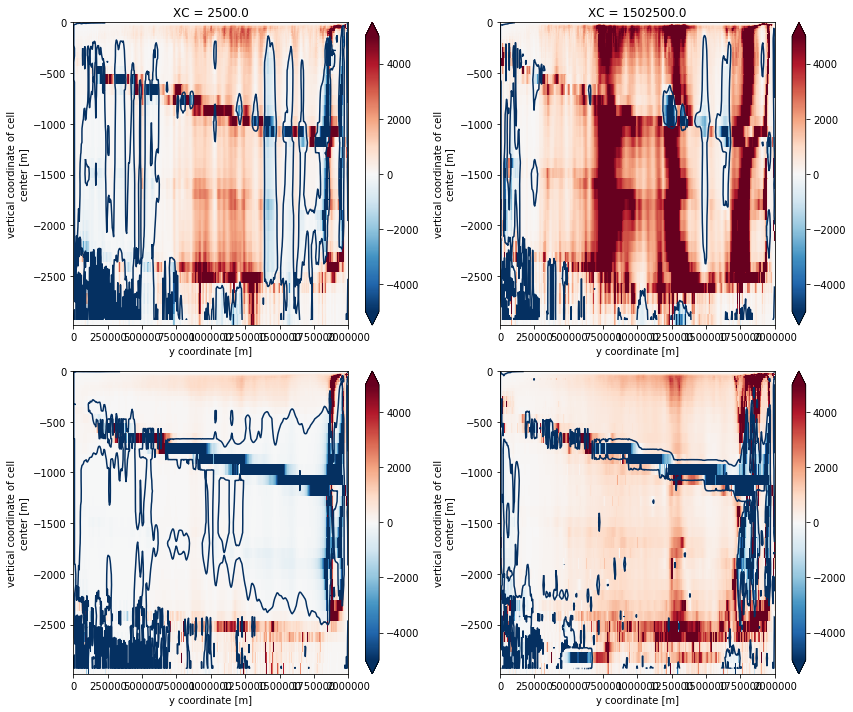

In [79]:
fig = plt.figure(figsize=(12,10))

fig.add_subplot(221)
Kwpbp.sel(XC=0, method='nearest').plot(vmin=-5000)
Kwpbp.sel(XC=0, method='nearest').plot.contour(levels=[0])

fig.add_subplot(222)
Kwpbp.sel(XC=1500e3, method='nearest').plot(vmin=-5000)
Kwpbp.sel(XC=1500e3, method='nearest').plot.contour(levels=[0])


fig.add_subplot(223)
Kwpbp.sel(XC=slice(0, 800e3)).mean('XC').plot(vmin=-5000)
Kwpbp.sel(XC=slice(0, 800e3)).mean('XC').plot.contour(levels=[0])


fig.add_subplot(224)
Kwpbp.sel(XC=slice(1200, 2000e3)).mean('XC').plot(vmin=-5000)
Kwpbp.sel(XC=slice(1200, 2000e3)).mean('XC').plot.contour(levels=[0])

plt.tight_layout()


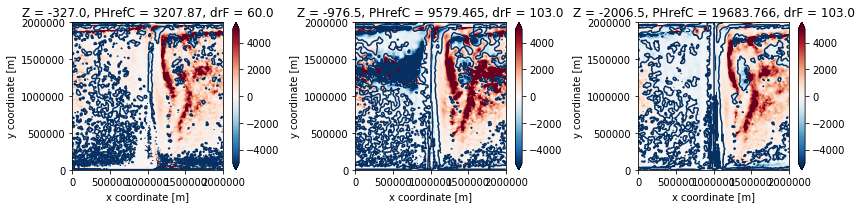

In [81]:
fig = plt.figure(figsize=(12,3))

fig.add_subplot(131)
Kwpbp.sel(Z=-300, method='nearest').plot(vmin=-5000)
Kwpbp.sel(Z=-300, method='nearest').plot.contour(levels=[0])

fig.add_subplot(132)
Kwpbp.sel(Z=-1000, method='nearest').plot(vmin=-5000)
Kwpbp.sel(Z=-1000, method='nearest').plot.contour(levels=[0])

fig.add_subplot(133)
Kwpbp.sel(Z=-2000, method='nearest').plot(vmin=-5000)
Kwpbp.sel(Z=-2000, method='nearest').plot.contour(levels=[0])

plt.tight_layout()


# Errors in reconstructing buoyancy fluxes 

\begin{equation}
E(\overline{u_i'b'}) = \frac{|\overline{u_i'b'} + R_{ij}\nabla \overline{b}|}{|\overline{u_i'b'}|} 
\end{equation}

In [95]:
Ktensor = xr.open_dataarray('Ktensor_5km.nc')

In [96]:
Ktensor

<xarray.DataArray (Z: 40, YC: 400, XC: 400, i: 3, j: 3)>
[57600000 values with dtype=float32]
Coordinates:
  * Z        (Z) float32 -5.0 -15.0 -25.0 -36.0 ... -2727.5 -2830.5 -2933.5
  * YC       (YC) float32 2500.0 7500.0 12500.0 ... 1992500.0 1997500.0
  * XC       (XC) float32 2500.0 7500.0 12500.0 ... 1992500.0 1997500.0
    rA       (YC, XC) float32 ...
    Depth    (YC, XC) float32 ...
    drF      (Z) float32 ...
    PHrefC   (Z) float32 ...
    hFacC    (Z, YC, XC) float32 ...
Dimensions without coordinates: i, j

In [112]:
recUflux = Ktensor.sel(i=0, j=0)*bgrads.dcdx + Ktensor.sel(i=0, j=1)*bgrads.dcdy + Ktensor.sel(i=0, j=2)*bgrads.dcdz
recVflux = Ktensor.sel(i=1, j=0)*bgrads.dcdx + Ktensor.sel(i=1, j=1)*bgrads.dcdy + Ktensor.sel(i=1, j=2)*bgrads.dcdz
recWflux = Ktensor.sel(i=2, j=0)*bgrads.dcdx + Ktensor.sel(i=2, j=1)*bgrads.dcdy + Ktensor.sel(i=2, j=2)*bgrads.dcdz

In [113]:
errUflux = np.abs(upbp + recUflux)/np.abs(upbp)
errVflux = np.abs(vpbp + recVflux)/np.abs(vpbp)
errWflux = np.abs(wpbp + recWflux)/np.abs(wpbp)

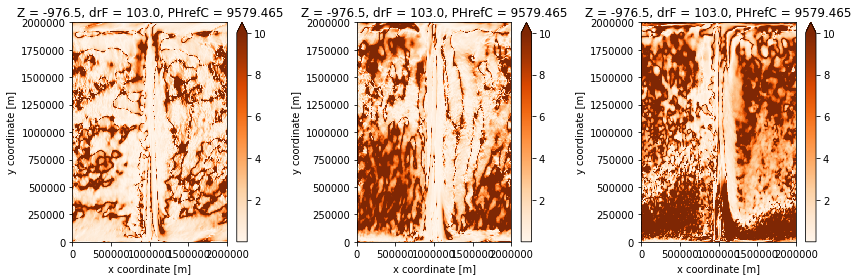

In [117]:
fig = plt.figure(figsize=(12,4))

fig.add_subplot(131)
errUflux.sel(Z=-1000, method='nearest').plot(vmax=10, cmap='Oranges')

fig.add_subplot(132)
errVflux.sel(Z=-1000, method='nearest').plot(vmax=10, cmap='Oranges')

fig.add_subplot(133)
errWflux.sel(Z=-1000, method='nearest').plot(vmax=10, cmap='Oranges')

plt.tight_layout()

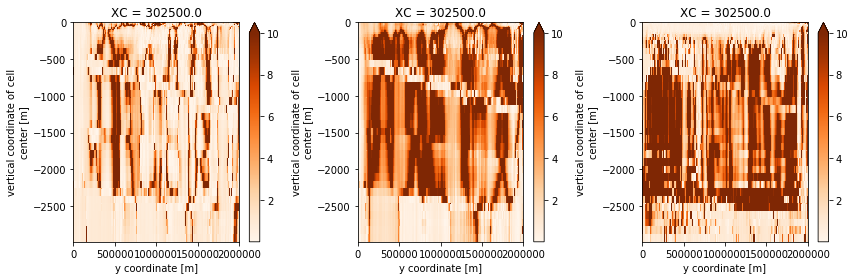

In [118]:
fig = plt.figure(figsize=(12,4))

fig.add_subplot(131)
errUflux.sel(XC=300e3, method='nearest').plot(vmax=10, cmap='Oranges')

fig.add_subplot(132)
errVflux.sel(XC=300e3, method='nearest').plot(vmax=10, cmap='Oranges')

fig.add_subplot(133)
errWflux.sel(XC=300e3, method='nearest').plot(vmax=10, cmap='Oranges')

plt.tight_layout()

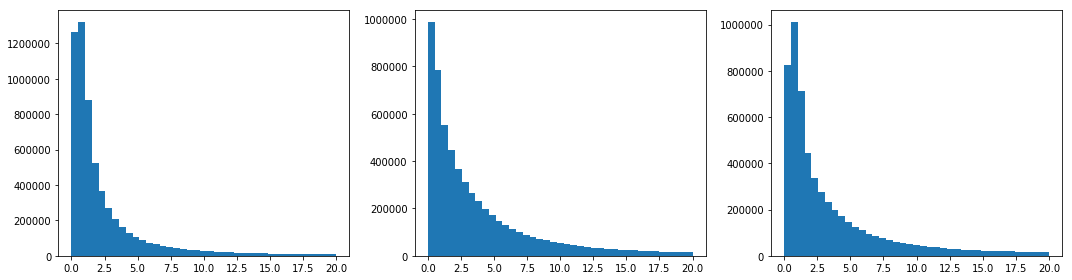

In [141]:
fig = plt.figure(figsize=(15,4))

fig.add_subplot(131)
A = plt.hist((errUflux.where(~np.isnan(errUflux), drop=True)).data.reshape(-1), bins=np.linspace(0,20,40), range=(0,100))

fig.add_subplot(132)
A = plt.hist((errVflux*Model_tav.hFacC).data.reshape(-1), bins=np.linspace(0,20,40), range=(0,100))

fig.add_subplot(133)
A = plt.hist((errWflux*Model_tav.hFacC).data.reshape(-1), bins=np.linspace(0,20,40), range=(0,100))

plt.tight_layout()

In [166]:
A = np.array(errUflux.data.reshape(-1))
np.percentile(A[np.argwhere(~np.isnan(A))] , 95)

18.600099182128872

In [167]:
A = np.array(errVflux.data.reshape(-1))
np.percentile(A[np.argwhere(~np.isnan(A))] , 95)

36.03474864959709

In [168]:
A = np.array(errWflux.data.reshape(-1))
np.percentile(A[np.argwhere(~np.isnan(A))] , 95)

51.486407470702716